# Линейные модели в машинном обучении

#### Описание проекта

К нам обратился фермер, владелец молочного хозяйства. Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма». Он просит нас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах.

#### Цель проекта:

Обработать и проанализировать данные, полученные от "ЭкоФерма", и на их основе построить две модели, которые будут определять удой коров в год и вкус молока, что поможет выбрать правильных бурёнок фермеру.

In [1]:
!pip install phik -q

In [2]:
# импортируем все нужные в работе библиотеки в отдельной ячейке
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from IPython.display import display
import scipy.stats as st

import phik
from phik import phik_matrix

# импортирую отдельно части sklearn, чтобы не путаться лишний раз
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix

## Загрузка данных

In [3]:
# загружаем предоставленные данные
ferma_main_df = pd.read_csv('/datasets/ferma_main.csv', sep =';', decimal = ',')
ferma_dad_df = pd.read_csv('/datasets/ferma_dad.csv', sep =';')
cow_buy_df = pd.read_csv('/datasets/cow_buy.csv', sep =';', decimal = ',')

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента v.1</b> 
    
Принято
</div>

In [4]:
# отдельная функция чтобы не писать одно и тоже
def data_info(dataframe):
    print(dataframe.info())
    display(dataframe.head())
    display(dataframe.describe())
    print('Пропусков в датафрейме: ', dataframe.isnull().sum())
    print()
    print('Количество явных дубликатов в датафрейме:', dataframe.duplicated().sum())

In [5]:
data_info(ferma_main_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Жирность,%","Белок,%"
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,317.460568,6187.025237,14.542744,1922.682965,0.912855,3.603943,3.075666
std,183.096982,1638.401021,1.301301,182.392548,0.032209,0.168020,0.002540
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,159.250000,5751.750000,13.500000,1772.250000,0.890000,3.590000,3.074000
50%,317.500000,6130.500000,14.700000,1880.500000,0.930000,3.650000,3.076000
75%,475.750000,6501.000000,15.600000,2058.750000,0.940000,3.720000,3.077000
max,629.000000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Пропусков в датафрейме:  id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64

Количество явных дубликатов в датафрейме: 5


In [6]:
data_info(ferma_dad_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


,id
count,629.00000
mean,315.00000
std,181.72094
min,1.00000
25%,158.00000
50%,315.00000
75%,472.00000
max,629.00000


Пропусков в датафрейме:  id          0
Имя Папы    0
dtype: int64

Количество явных дубликатов в датафрейме: 0


In [7]:
data_info(cow_buy_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB
None


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


,"Текущая_жирность,%","Текущий_уровень_белок,%"
count,20.000000,20.000000
mean,3.577500,3.069500
std,0.126818,0.010339
min,3.340000,3.046000
25%,3.510000,3.064000
50%,3.590000,3.074000
75%,3.650000,3.076000
max,3.770000,3.081000


Пропусков в датафрейме:  Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64

Количество явных дубликатов в датафрейме: 4


#### Промежуточный вывод

Пропусков в данных не обнаружено. Название колонок требуется привести к нижнему регистру. В датасетах cow_buy_df и ferma_main_df обнаружены явные дубликаты. В ferma_main_df в ходе предобработки они будут удалены. После приведения к нижнему регистру также будет проверка на неявные дубликаты.

##  Предобработка данных

Приводим названия столбцов к нижнему регистру

In [8]:
# команды однострочные, поэтому обойдемся без написания функции
ferma_main_df.columns = ferma_main_df.columns.str.lower()
cow_buy_df.columns =  cow_buy_df.columns.str.lower()
ferma_dad_df.columns = ferma_dad_df.columns.str.lower()


В ходе первого осмотра выяснили, что в двух датасетах есть явные дубликаты, но так как cow_buy_df нужен будет для предсказания, то в нем оставим. Таким образом удалим дубликаты из ferma_main_df.

In [9]:
ferma_main_df.drop_duplicates(keep =False, inplace=True)
# проверям
print(ferma_main_df.duplicated().sum())

0


Также обнаружено, что в типах пастища и породы папы быка есть неявные дубликаты.

In [10]:
# Напишем функцию, которая изменит окончания слов
def transform_category(word):
    # Преобразуем значение в строку, чтобы работала обработка 
     if word == 'Айдиалл':
            return 'Айдиал'
     if word == 'Равнинные':
        return 'Равнинное' 
     return word
ferma_main_df['тип пастбища'] = ferma_main_df['тип пастбища'].apply(transform_category)
ferma_main_df['тип пастбища'] = ferma_main_df['тип пастбища'].str.lower()
ferma_main_df['порода папы_быка'] = ferma_main_df['порода папы_быка'].apply(transform_category)


Перейдем к обработке типов данных столбцов. Начнем с датасета ferma_main_df.

In [11]:
# преобразуем выбранные колонки в категориальный тип
categorical_columns = ['порода', 'тип пастбища', 'порода папы_быка', 'вкус молока', 'возраст']

#также пройдем через цикл
for col in categorical_columns:
    ferma_main_df[col] = ferma_main_df[col].astype('category')
    
ferma_main_df.dtypes

id                                          int64
удой, кг                                    int64
эке (энергетическая кормовая единица)     float64
сырой протеин, г                            int64
спо (сахаро-протеиновое соотношение)      float64
порода                                   category
тип пастбища                             category
порода папы_быка                         category
жирность,%                                float64
белок,%                                   float64
вкус молока                              category
возраст                                  category
dtype: object

В ferma_dad_df преобразуем имя папы в категориальный признак.

In [12]:
ferma_dad_df['имя папы'] = ferma_dad_df['имя папы'].astype('category')
ferma_dad_df.dtypes

id             int64
имя папы    category
dtype: object

В последнем датасете аналогично, жирность и белок во float, остальные в категориальный признак.

In [13]:
# преобразование категорий
categorical_columns2 = ['порода', 'тип пастбища', 'порода папы_быка', 'имя_папы', 'возраст']
for col in categorical_columns2:
    cow_buy_df[col] = cow_buy_df[col].astype('category')
cow_buy_df.dtypes

порода                     category
тип пастбища               category
порода папы_быка           category
имя_папы                   category
текущая_жирность,%          float64
текущий_уровень_белок,%     float64
возраст                    category
dtype: object

На пропуски датафрейм был проверен в самом начале, пропусков нет.

####  Промежуточный вывод

В ходе предъобработки в датасеты были внесены следующие изменения:
* все названия колонок приведены к нижнему регистру
- типы столбцов были изменены на соответствующие 
- явные и неявные дубликаты были удалены
- проверка на пропуски показала, что пропусков нет

## Исследовательский анализ данных

Перед началом анализа, создадим лист numeric columns.

In [14]:
numeric_columns = ['удой, кг', 'эке (энергетическая кормовая единица)',
       'сырой протеин, г', 'спо (сахаро-протеиновое соотношение)', 'жирность,%', 'белок,%']

In [15]:
# Выведем описательную статистику для числовых признаков
ferma_main_df[numeric_columns].describe()

,"удой, кг",эке (энергетическая кормовая единица),"сырой протеин, г",спо (сахаро-протеиновое соотношение),"жирность,%","белок,%"
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,6189.098726,14.544108,1923.501592,0.913169,3.603599,3.075672
std,1646.083387,1.307437,183.069552,0.032201,0.168784,0.002551
min,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,5749.750000,13.500000,1770.500000,0.890000,3.590000,3.074000
50%,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,6501.250000,15.600000,2062.250000,0.940000,3.720000,3.077000
max,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Построим гистограмму распределения числовых признаков.

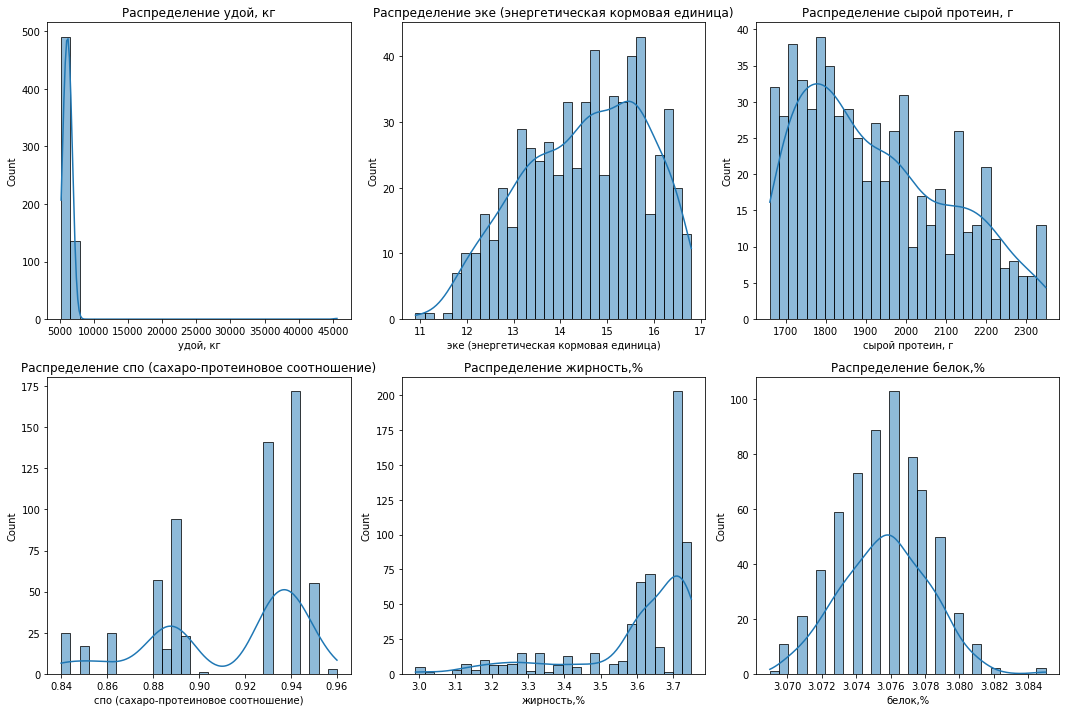

In [16]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(ferma_main_df[col], kde=True, bins=30)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

Дополнительно построим boxplot для выявления выбросов.

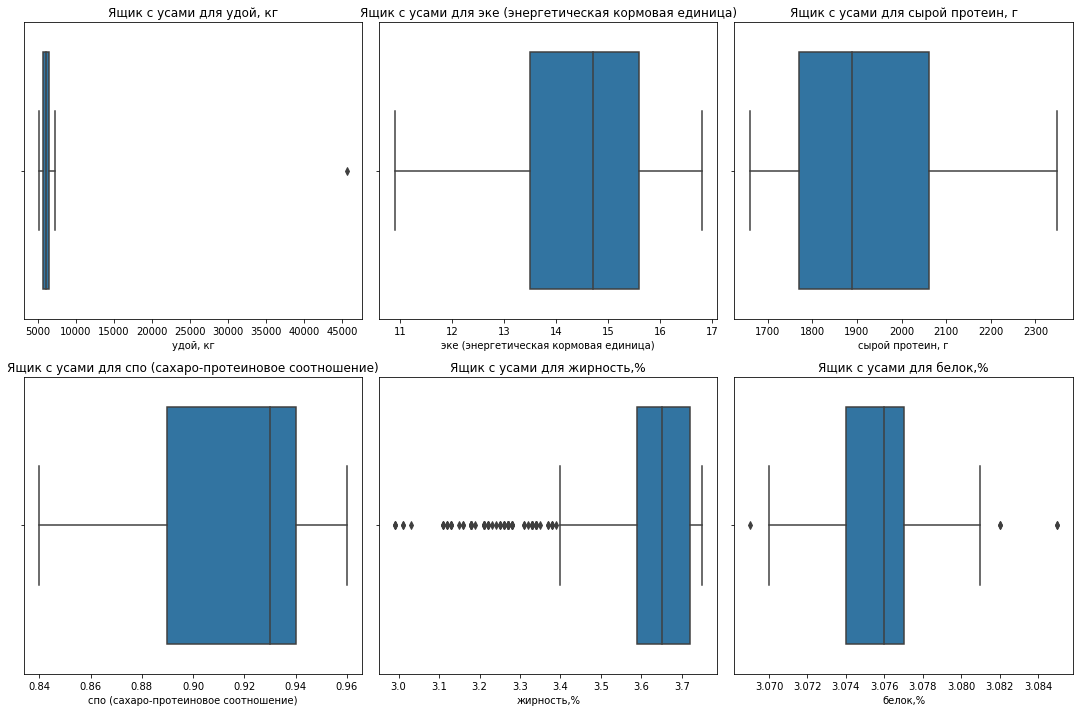

In [17]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=ferma_main_df[col])
    plt.title(f'Ящик с усами для {col}')
plt.tight_layout()
plt.show()

In [18]:
ferma_main_df[ferma_main_df['удой, кг'] > 7500]
# так как у нас всего лишь одна строка,
# спокойно удалим ее.

,id,"удой, кг",эке (энергетическая кормовая единица),"сырой протеин, г",спо (сахаро-протеиновое соотношение),порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет


In [19]:
ferma_main_df = ferma_main_df.loc[ferma_main_df['удой, кг'] < 7500]

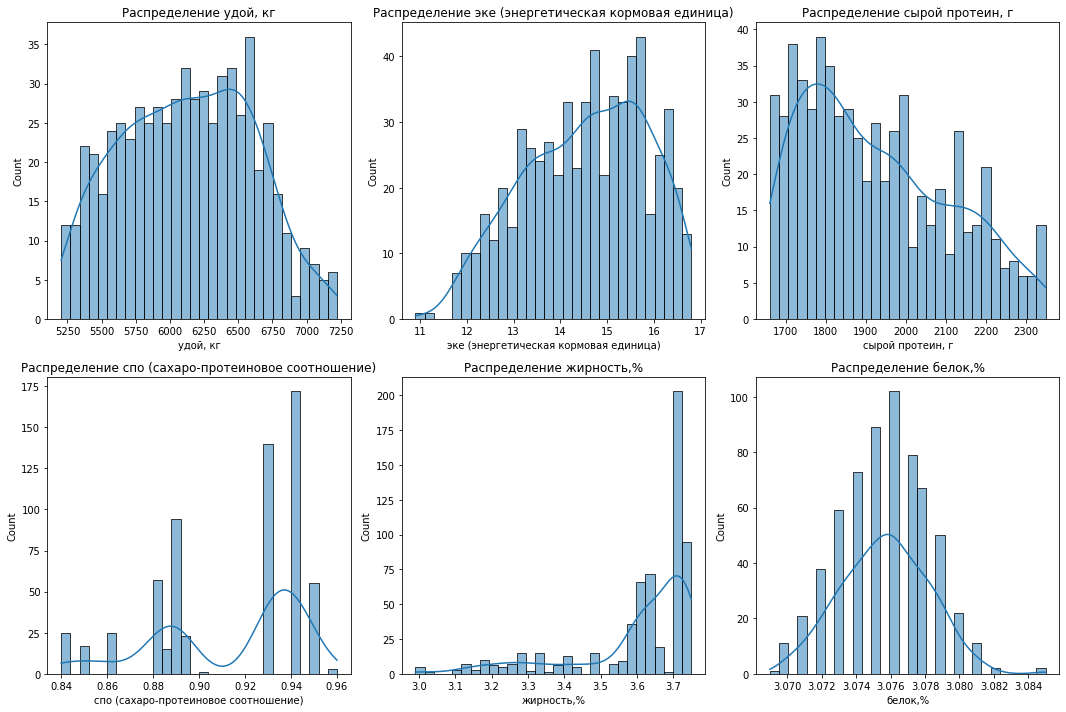

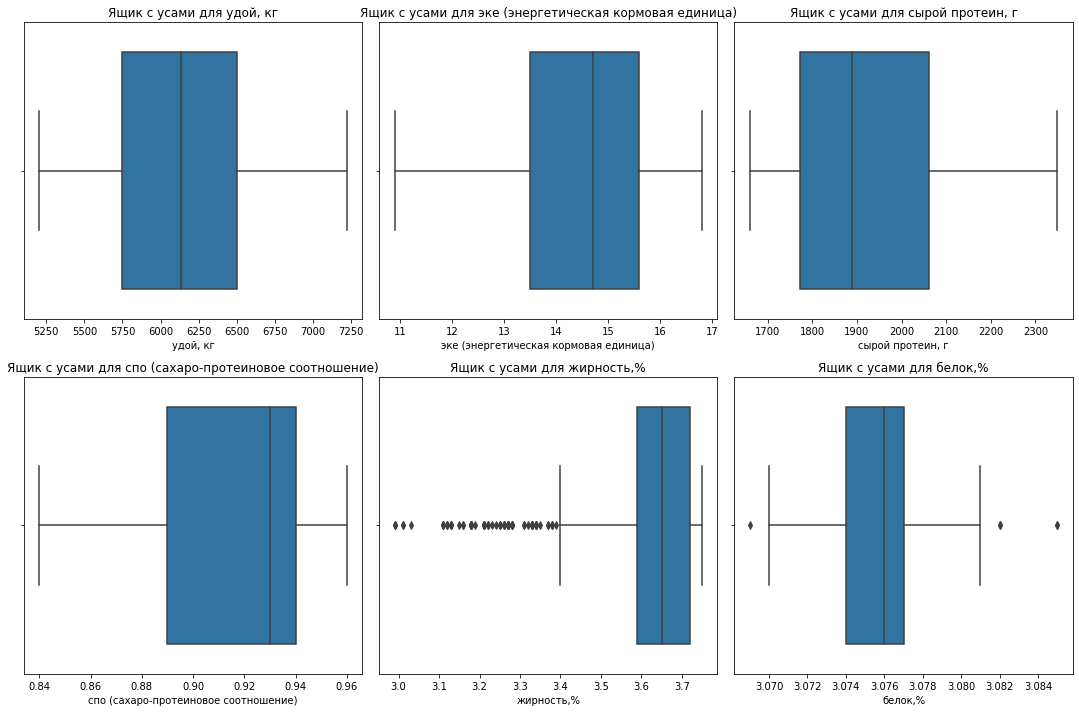

In [20]:
# Перерисовка графиков, после удаления выброса в колонке с удоем
# гистограмма
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(ferma_main_df[col], kde=True, bins=30)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

# боксплот
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=ferma_main_df[col])
    plt.title(f'Ящик с усами для {col}')
plt.tight_layout()
plt.show()

#### Промежуточный вывод по количественным признакам:

Удалена строка с выбросом в колонке "удой". Все остальные данные выглядят более-менее реалистично. Графики распределений: "удой", "эке", "распределение белка" похожи на нормальное распределение, но слегка асимметричные. График распределения "сырой протеин" - ненормальное. Что касается "СПО", "жирность", трудно назвать правильную характеристику распределения. У "СПО" два пика. А график жирности напоминает сильно скошенное вправо нормальное распределение.


Проанализируем категориальные признаки.

In [21]:
print("\nЧастота значений для категориальных признаков:")
for col in categorical_columns:
    print(f"\n{col}:")
    print(ferma_main_df[col].value_counts())


Частота значений для категориальных признаков:

порода:
Вис Бик Айдиал     372
РефлешнСоверинг    255
Name: порода, dtype: int64

тип пастбища:
холмистое    349
равнинное    278
Name: тип пастбища, dtype: int64

порода папы_быка:
Айдиал     317
Соверин    310
Name: порода папы_быка, dtype: int64

вкус молока:
вкусно       370
не вкусно    257
Name: вкус молока, dtype: int64

возраст:
более_2_лет    517
менее_2_лет    110
Name: возраст, dtype: int64


Построим визуализацию распределения категориальных признаков

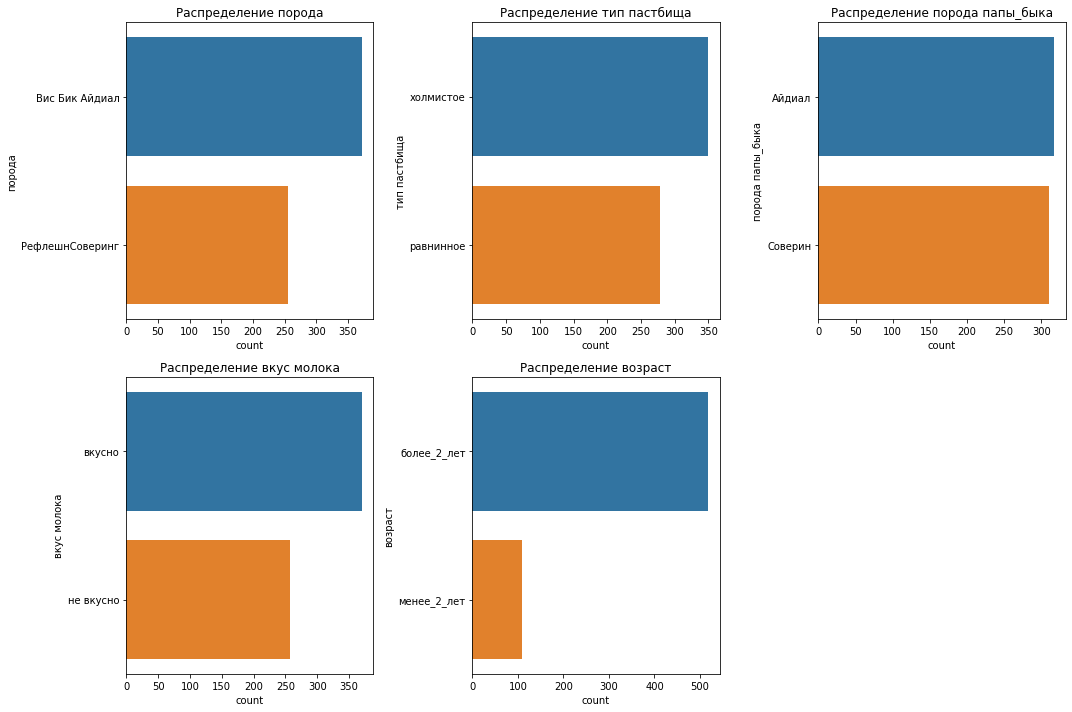

In [22]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(y=ferma_main_df[col], order=ferma_main_df[col].value_counts().index)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

#### Промежуточный вывод по категориальным признакам:

* Порода "Вис Бик Айдиал" встречается чаще, чем "РефлешнСоверинг".
- Большинство коров пасутся на равнинных пастбищах.
- Вкус молока чаще оценивается как "вкусно".
- Большинство коров старше 2-х лет.
- в типах пастбищ 60% - холмистые
- порода папы быка встречается с практически одинаковой частотой

## Корреляционный анализ

Проведем корелляционный анализ числовых признаков, построим матрицу корелляции

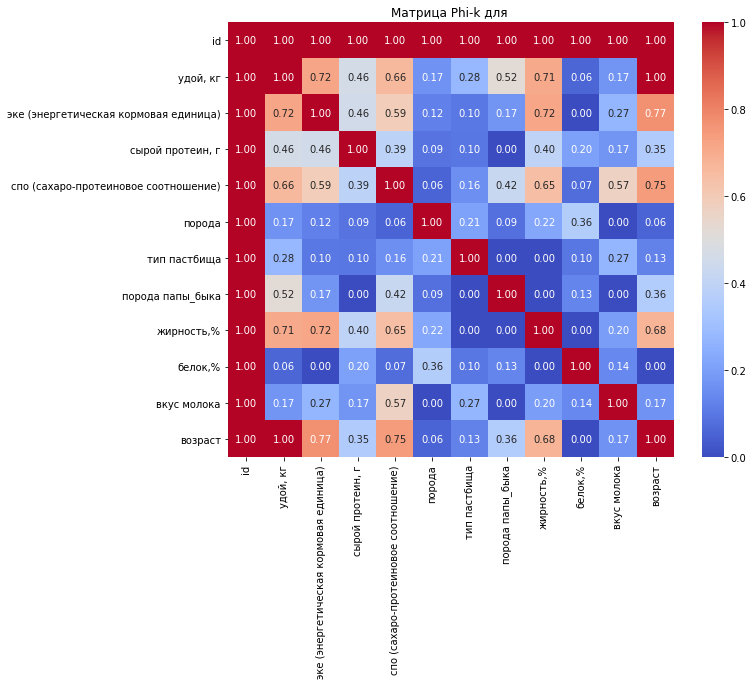

In [23]:
plt.figure(figsize=(10, 8))
phik_corr_matrix = ferma_main_df.phik_matrix(numeric_columns)
#phik_corr_matrix = ferma_main_df['numeric_columns'].phik_matrix()
sns.heatmap(phik_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица Phi-k для ')
plt.show()

Теперь построим диаграммы рассеяния для "Удой,кг" и всех количественных признаков.

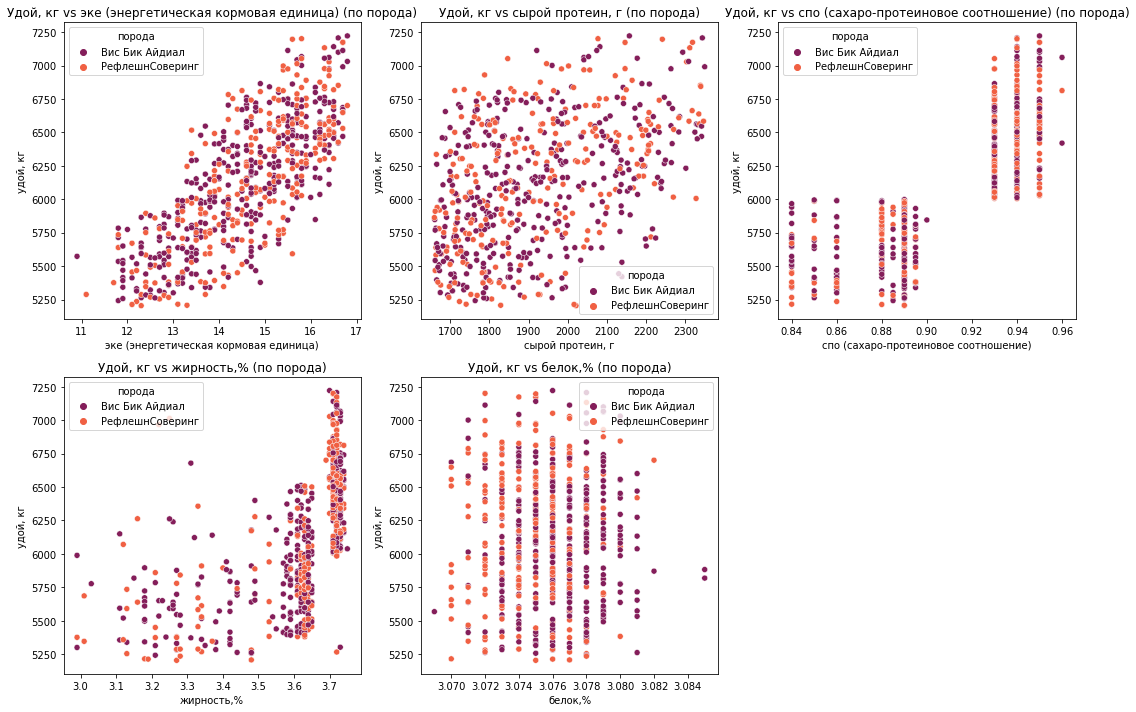

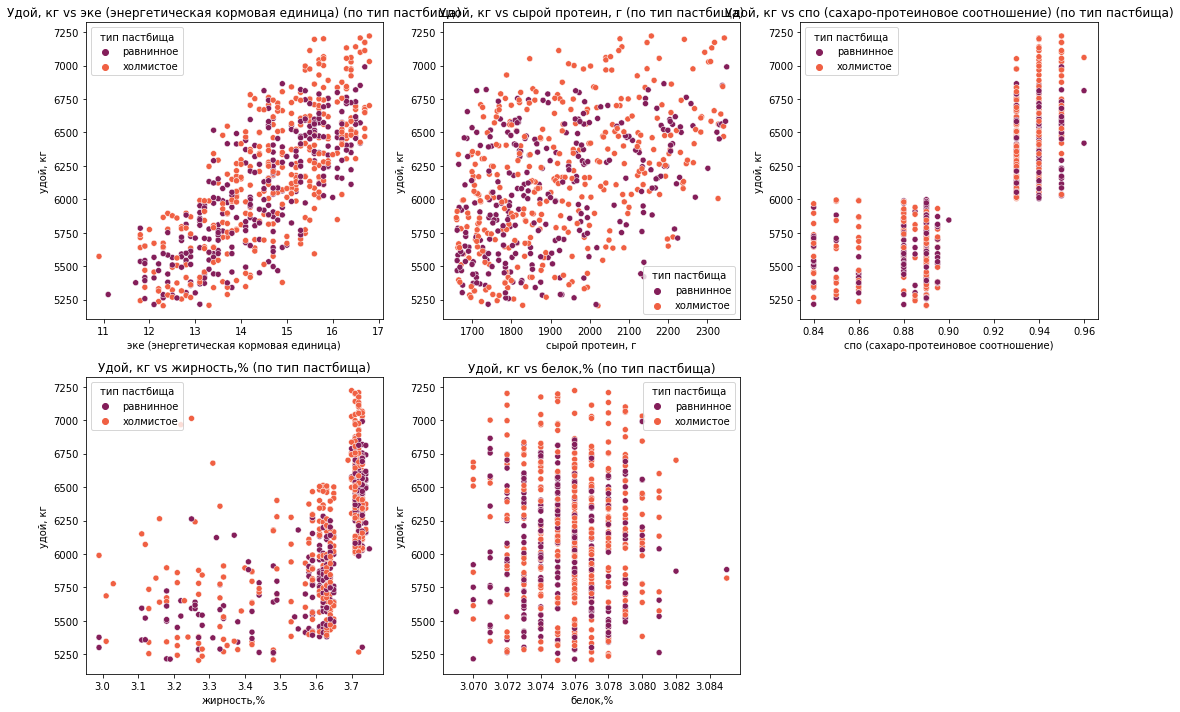

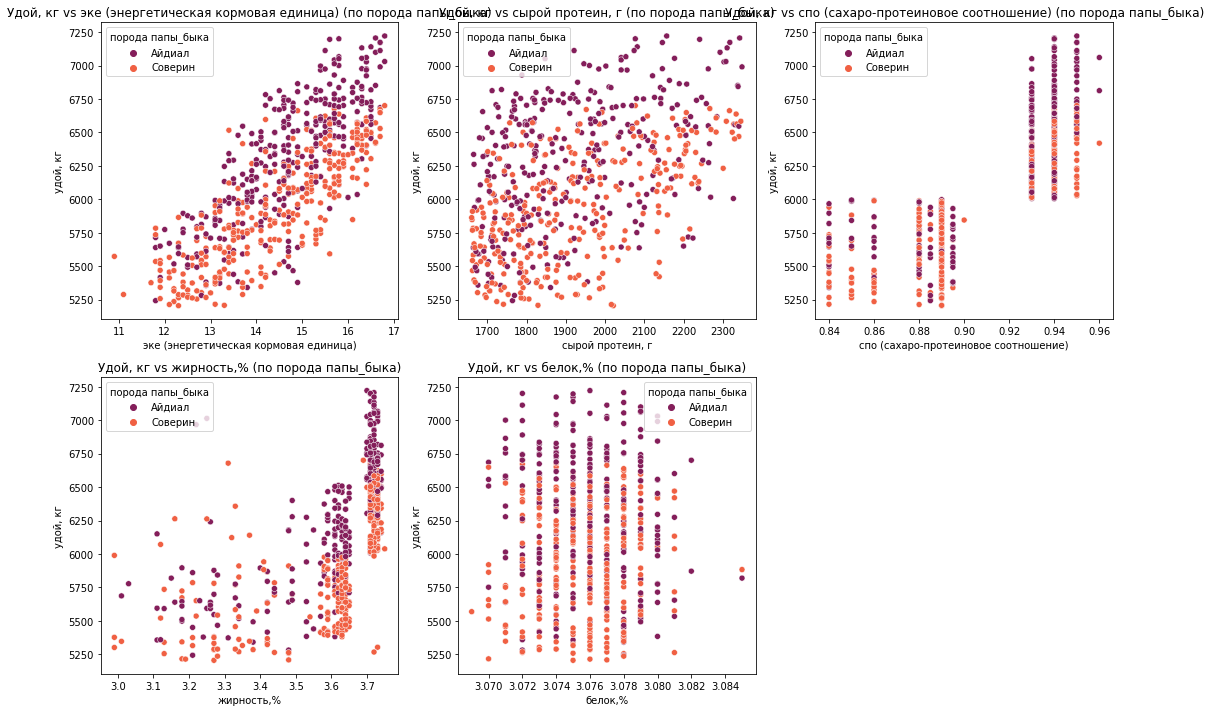

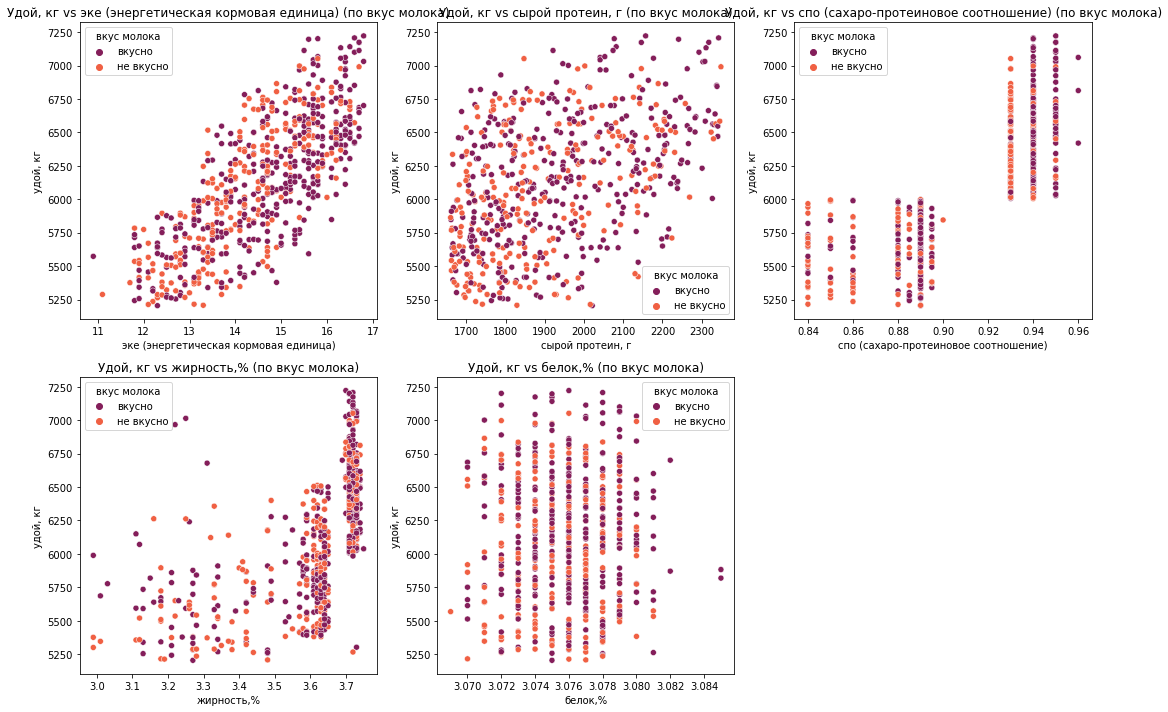

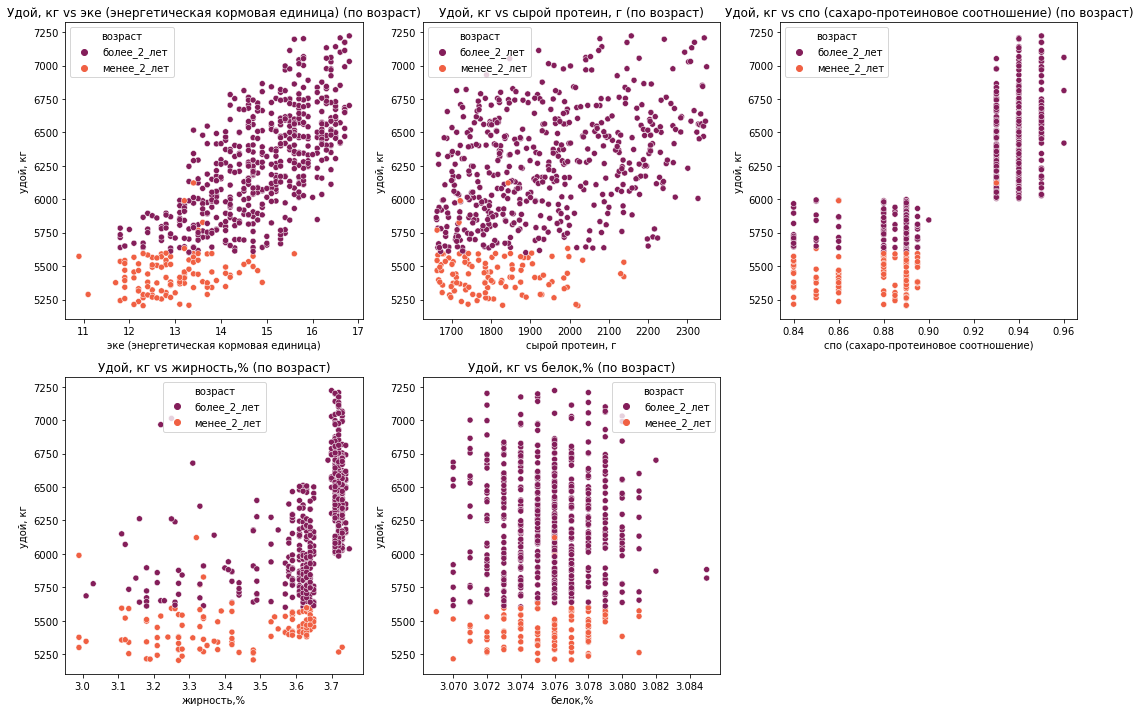

In [24]:
# диаграмма рассения
for cat_col in categorical_columns:
    plt.figure(figsize=(15, 10))
    for i, num_col in enumerate(numeric_columns[1:], 1):  # Исключаем "Удой, кг"
        plt.subplot(2, 3, i)
        sns.scatterplot(x=num_col, y='удой, кг', hue=cat_col, data=ferma_main_df, palette='rocket')
        plt.title(f'Удой, кг vs {num_col} (по {cat_col})')
    plt.tight_layout()
    plt.show()
# по заданию, нам требовалось построить с учетом ВСЕХ категориальных признаков
# но они как будто одинаковые, и достаточно первых 5 графиков, по породе, например
# я пока оставляю как есть, жду вашего коментария по этому поводу

#### Промежуточный вывод:
Итак, на основе диаграмм рассения можно сделать следующий вывод:
* Удой линейно возрастает с увеличением ЭКЕ, высокая корелляция (0.76)
- также удой нелинейно возрастает с увеличением СПО молока

По остальным данным довольно низкая корелляция, поэтому нельзя с уверенностью сказать о зависимости этих признаков от удоя. Я думаю, в данном случае не нужно вводить дополнительные целевые признаки, достаточно будет исключить нелинейные связи(как эке, например).


Мультиколлинеарность между признаками не превышает 0.8. Поэтому можем сказать, что между входными признаками мультиколлинеарность не наблюдается

## Обучение модели линейной регрессии

#### Обучение первой модели, v1
Обучим модель линейной регрессии, выбрав в качестве целевого признака - Удой,кг. В качестве входных признаков выберем:
* Количественные: ЭКЕ, сырой протеин, жирность, белок.
- Категориальные: порода, тип пастбища.

ЭКЕ: энергетическая ценность корма влияет на продуктивность коров.
Жирность и белок: качество молока может коррелировать с удоем, но зависимость слабая.


#### Обучение первой модели, v2
Обучим модель линейной регрессии, выбрав в качестве целевого признака - Удой,кг. В качестве входных признаков выберем:
* Количественные: "ЭКЕ", сырой протеин, СПО
- Категориальные: порода, "порода папы", "тип пастбища", "возраст"
ЭКЕ: энергетическая ценность корма влияет на продуктивность коров.
Порода и тип пастбища: эти факторы могут влиять на продуктивность.
Порода папы и возраст также влияют, так разные породы могут в среднем давать больше или меньше молока, аналогично и с возрастом, более "взрослые" коровы могут давать больше молока, чем молодый, или наборот.

In [25]:
#Создадим функцию для рассчета метрик
def metrica(y_test, y_predict):
    r2 = r2_score(y_test,  y_predict)
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = mean_squared_error(y_test, y_predict, squared=False)
    print(f"R2 LinearRegression = {r2:.3f}")
    print(f"MAE LinearRegression = {mae:.0f}")
    print(f"MSE LinearRegression = {mse:.3f}")
    print(f"RMSE LinearRegression = {rmse:.0f}")
    #анализ остатков
    residuals = y_test - y_predict
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    plt.title('Диаграмма рассения остатков')
    plt.show()

In [26]:
ferma_main_df.columns

Index(['id', 'удой, кг', 'эке (энергетическая кормовая единица)',
       'сырой протеин, г', 'спо (сахаро-протеиновое соотношение)', 'порода',
       'тип пастбища', 'порода папы_быка', 'жирность,%', 'белок,%',
       'вкус молока', 'возраст'],
      dtype='object')

Подготовим данные для машинного обучения, обучим и оценим качество модели.

R2 LinearRegression = 0.783
MAE LinearRegression = 171
MSE LinearRegression = 46487.361
RMSE LinearRegression = 216


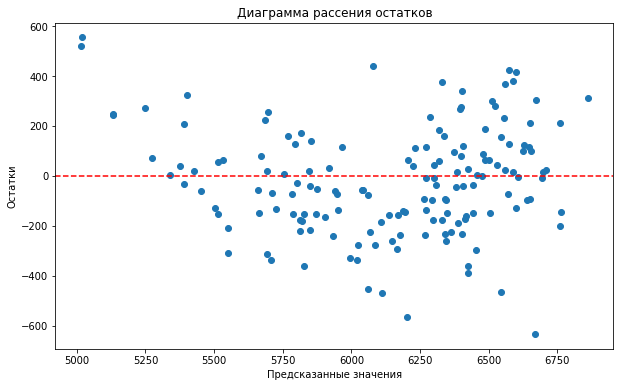

In [27]:
# создаем константу для воспроизводимости результата
RANDOM_STATE = 42

# формируем выборки тренировочных и тестовых данных
X = ferma_main_df.drop(['удой, кг', 'id', 'жирность,%', 'белок,%', 'вкус молока'], axis=1)
y = ferma_main_df['удой, кг']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)
# list с категориальными признаками
cat_col = ['порода', 'тип пастбища','возраст', 'порода папы_быка']
num_col = ['эке (энергетическая кормовая единица)', 'сырой протеин, г', 'спо (сахаро-протеиновое соотношение)']

# кодируем категориальные признаки, избегаем дамми ловушки
ohe = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = ohe.fit_transform(X_train[cat_col])
X_test_ohe = ohe.transform(X_test[cat_col])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names())
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names())

# Масштабирование количественных признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col])
X_test_scaled = scaler.transform(X_test[num_col])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train_prep = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_prep = pd.concat([X_test_ohe, X_test_scaled], axis=1)
# инициализируем модель линейной регрессии
model_lr_one  = LinearRegression()
model_lr_one.fit(X_train_prep, y_train)
predictions = model_lr_one.predict(X_test_prep)

# рассчитаем метрики
metrica(y_test, predictions)

~~Мы получили значение MAE 180, то есть в среднем отклонение от реальных показателей не так велико, так как значения удоя колеблятся от 5000 до 7500.
Также нашли коэффициент детерминации, таким образом, модель угадывает правильные ответы в 79,3% случаев.~~

В результате разработки первой модели, мы получили такие значения метрик:

* R2 LinearRegression = 0.783
- MAE LinearRegression = 171
- MSE LinearRegression = 46487.361
- RMSE LinearRegression = 216

Сделаем выводы:
Исходя из метрики R2, наша модель предсказывает на 78% лучше, чем если бы мы пытались предсказать по средним значениям. В целом результат неплохой. RMSE больше MAE всего в 1.2 раза, таким образом можно сказать, что выбросов в данных мало. Учитывая, что значения удоя колеблятся от 5000 до 7500, можем сделать вывод, что, ошибка достаточно мала, около 4%.

На диаграмме мы можем увидеть чередование низкой и высокой дисперсии остатков. Скорее всего, так как модель неидеальна, поэтому на графике такой несимметричный разброс. Также модель немного завышает значения для низкого удоя. Я думаю нужны дополнительные исследования.

### Обучение 2 модели линейной регрессии

Теперь обучим вторую модель линейной регрессии. Для этого исключим нелинейность, преобразуем признак "СПО" в категориальный бинарный признак, выбрав границу категорий 0,91. Также преобразуем признак "ЭКЕ" в "ЭКЕ в квадрате".

In [28]:
#создадим новую колонку с бинарным признаком в датафрейме ferma_main
ferma_main_df['спо (сахаро-протеиновое соотношение)'] = ferma_main_df['спо (сахаро-протеиновое соотношение)'].apply(lambda x: 1 if x > 0.91 else 0)
# теперь добавим еще одну, ЭКЕ^2
ferma_main_df['эке_квадрат'] = ferma_main_df['эке (энергетическая кормовая единица)'] **2

In [29]:
# посмотрим как выглядит датафрейм
ferma_main_df.columns

Index(['id', 'удой, кг', 'эке (энергетическая кормовая единица)',
       'сырой протеин, г', 'спо (сахаро-протеиновое соотношение)', 'порода',
       'тип пастбища', 'порода папы_быка', 'жирность,%', 'белок,%',
       'вкус молока', 'возраст', 'эке_квадрат'],
      dtype='object')

Приступим к обучению модели.

R2 LinearRegression = 0.822
MAE LinearRegression = 154
MSE LinearRegression = 38201.708
RMSE LinearRegression = 195


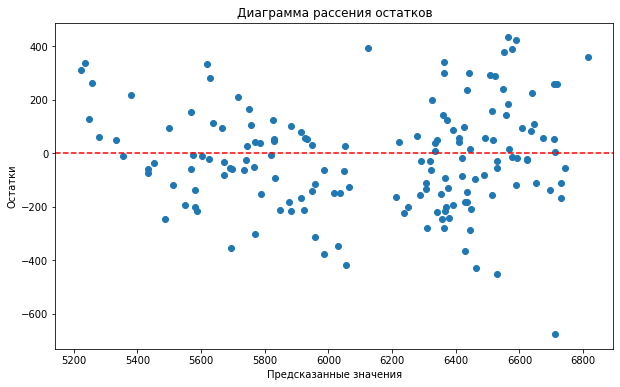

In [30]:
# Обозначим входные признаки
X = ferma_main_df[['эке_квадрат', 'сырой протеин, г', 'спо (сахаро-протеиновое соотношение)',
                   'порода','тип пастбища', 'порода папы_быка', 'возраст' ]]
# Целевой признак
y = ferma_main_df['удой, кг']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# новые листы с категориальными и количественными переменными
cat_column=['порода',
       'тип пастбища', 'порода папы_быка', 'возраст', 'спо (сахаро-протеиновое соотношение)']
num_column=['эке_квадрат', 'сырой протеин, г']

# Кодируем категориальные признаки
ohe = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = ohe.fit_transform(X_train[cat_column])
X_test_ohe = ohe.transform(X_test[cat_column])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names())
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names())

# Масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_column])
X_test_scaled = scaler.transform(X_test[num_column])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_column)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_column)

# Объединим все преобразованные данные в тренировочный и тестовый датафреймы
X_train_prep = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_prep = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# Обучение модели
model_lr_two = LinearRegression()
model_lr_two.fit(X_train_prep, y_train)

# Оценка качества модели
predictions = model_lr_two.predict(X_test_prep)
# рассчитаем метрики
metrica(y_test, predictions)

#### Промежуточный вывод:
Полученные метрики:

* R2 LinearRegression = 0.822
- MAE LinearRegression = 154
- MSE LinearRegression = 38201.708
- RMSE LinearRegression = 195

Модель стала точнее предсказывать, r2 увеличился, модель предсказывает правильные ответы на 80% лучше, чем если бы заменили средними значениями.
МАЕ уменьшилась, данные более качественные, чем при обучении первой модели. Количество выбросов незначительно уменьшилось( если можно так трактовать RMSE)
Диаграмма рассеяния тут тоже чудит, но в этот раз занижает остатки при высоком удое, это чревато тем, что фермер может не купить хорошую корову. Диаграмма симметрична при высоких значениях удоя.

### Обучение 3 модели линейной регрессии.

Начнем с объединения ferma_main и ferma_dad по id. Также добавим колонку в категориальные признаки.

In [31]:
ferma_merged = pd.merge(ferma_main_df, ferma_dad_df, on='id', how='left' )
ferma_merged.head()

,id,"удой, кг",эке (энергетическая кормовая единица),"сырой протеин, г",спо (сахаро-протеиновое соотношение),порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст,эке_квадрат,имя папы
0,1,5863,14.2,1743,0,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,201.64,Буйный
1,2,5529,12.8,2138,0,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,163.84,Соловчик
2,3,5810,14.0,1854,0,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,196.00,Барин
3,4,5895,12.4,2012,0,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,153.76,Буйный
4,5,5302,12.8,1675,0,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,163.84,Барин


Приступим к обучению 3 модели линейной регрессии.

R2 LinearRegression = 0.829
MAE LinearRegression = 150
MSE LinearRegression = 36704.483
RMSE LinearRegression = 192


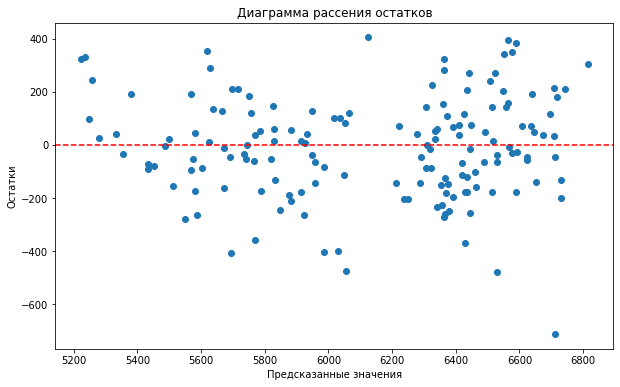

In [32]:
# в Входные признаки
X = ferma_merged[['эке_квадрат', 'сырой протеин, г', 'спо (сахаро-протеиновое соотношение)', 'порода', 'тип пастбища', 'возраст', 'порода папы_быка', 'имя папы']]
# Целевой признак
y = ferma_merged['удой, кг']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# листы для колонок
cat_col_names = ['спо (сахаро-протеиновое соотношение)', 'порода', 'тип пастбища', 'возраст', 'порода папы_быка', 'имя папы']
num_col_names = ['эке_квадрат', 'сырой протеин, г']

# Нормализуем категориальные признаки
ohe = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = ohe.fit_transform(X_train[cat_col_names])
X_test_ohe = ohe.transform(X_test[cat_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names())
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names())

# Масштабирование количественных признаков
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# объединяем данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# Обучение модели
model_lr_three = LinearRegression()
model_lr_three.fit(X_train, y_train)

# Оценка качества модели
predictions_three = model_lr_three.predict(X_test)
# рассчитаем метрики
metrica(y_test, predictions_three)

#### Промежуточный вывод.

Судя по метрикам, эта модель намного лучше первой, и ненамного второй. Остатки выглядят симметрично относительно 0. При анализе дисперсии ошибок при различных прогнозах можно заметить, что она более стабильна по сравнению с первой моделью. Можно сказать, что третья модель оказалась более точной. Таким образом, уменьшение нелинейности между входными признаками и целевым, а также добавление в расчет еще одного входного признака повлияло на модель в лучшую сторону.

Добавим сюда рассчет доверительного интервала.

In [33]:
st.t.interval(confidence=0.95, df=len(predictions_three)-1, loc=np.mean(predictions_three), scale=st.sem(predictions_three))

(6059.221070962349, 6194.802160063831)

Спрогнозируем удой коров при помощи 3 модели. Сначала добавим недостающие признаки +5%, и устраним нелинейность, также как при работе с предыдущей моделью.

In [34]:
# рассчитаем средение значения +5% и добавим их в датафрейм cow_buy
cow_buy_df['эке (энергетическая кормовая единица)'] = ferma_main_df['эке (энергетическая кормовая единица)'].mean() *1.05
cow_buy_df['сырой протеин, г'] = ferma_main_df['сырой протеин, г'].mean() *1.05
cow_buy_df['спо (сахаро-протеиновое соотношение)'] = ferma_main_df['спо (сахаро-протеиновое соотношение)'].mean() *1.05


In [35]:
# на этом этапе пришлось создать копию cow_buy_df,
# так как без этого не получилось обучить логистическую регрессию
cow_buy_df_copy = cow_buy_df.copy()

# устраняем нелинейность введя новые столбцы и преобразуем СПО в бинарный признак аналогично предыдущей модели
cow_buy_df_copy['спо (сахаро-протеиновое соотношение)'] = cow_buy_df['спо (сахаро-протеиновое соотношение)'].apply(lambda x: 1 if x > 0.91 else 0)
cow_buy_df_copy['эке_квадрат'] = cow_buy_df['эке (энергетическая кормовая единица)'].apply(lambda x: x**2)


In [36]:
# выделим листы для категориальных и числовых признаков
cat_col_names = ['спо (сахаро-протеиновое соотношение)', 'порода', 'тип пастбища', 'возраст', 'порода папы_быка', 'имя_папы']
num_col_names = ['эке_квадрат', 'сырой протеин, г']

# нормализуем категориальные признаки для прогноза
#encoder = OneHotEncoder(drop='first', sparse=False)
cow_buy_ohe = ohe.transform(cow_buy_df_copy[cat_col_names])
cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=ohe.get_feature_names())

# масштабируем количественные признаки
#scaler = StandardScaler()
cow_buy_scaled = scaler.transform(cow_buy_df_copy[num_col_names])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)


# Объединение данных
cow_buy_new = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)


In [37]:
# Прогнозирование удоя
cow_buy_new.columns = ['спо_менее_0.91',
                       'порода Рефлешн_Соверин',
                       'тип пастбища_холмистое',
                       'возраст_менее_2_лет',
                       'порода папы_Соверинг',
                       'имя папы_Буйный',
                       'имя папы_Геркулес',
                       'имя папы_Соловчик',
                       'эке_квадрат',
                       'сырой протеин, г']
predictions_cow_buy = model_lr_three.predict(cow_buy_new)
cow_buy_df['удой(кг)'] = predictions_cow_buy
cow_buy_df

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,эке (энергетическая кормовая единица),"сырой протеин, г",спо (сахаро-протеиновое соотношение),удой(кг)
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276411,2020.092823,0.619617,6258.279596
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276411,2020.092823,0.619617,6019.086077
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276411,2020.092823,0.619617,5928.580076
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276411,2020.092823,0.619617,6241.260709
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276411,2020.092823,0.619617,6190.301686
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276411,2020.092823,0.619617,6060.970423
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276411,2020.092823,0.619617,6258.279596
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276411,2020.092823,0.619617,6218.321027
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276411,2020.092823,0.619617,5928.580076
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276411,2020.092823,0.619617,6042.025759


### Вывод по цели работы
В результате проделанной работы был спрогнозирован годовой удой продаваемых коров, который варьируется от 5900 до 6260кг. Теперь необходимо спрогнозировать вкус молока. Для этой цели воспользуемся логистической регрессией.

## Обучение модели логистической регрессии

Спрогнозируем вкус молока, используем датафрейм ferma_merged - объединение из ferma_main, ferma_dad

In [38]:
# входные и целевые данные
X = ferma_merged[['эке_квадрат','сырой протеин, г', 'спо (сахаро-протеиновое соотношение)','порода папы_быка', 'имя папы', 'жирность,%', 'белок,%','тип пастбища','возраст','порода']]
y = ferma_merged['вкус молока']
y = y.apply(lambda x: 1 if x == 'вкусно' else 0)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)


# выделяем листы отдельно
cat_col_names = ['спо (сахаро-протеиновое соотношение)', 'тип пастбища', 'возраст']
num_col_names = ['эке_квадрат', 'сырой протеин, г', 'жирность,%', 'белок,%']

# Закодируем категориальные признаки OneHotEncoding
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

# Масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)


# объединяем данные в тренировочный и тестовый датафрейм
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# и обучим на них модель логистической регрессии
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Посчитаем веса коэффициентов:

In [39]:

for feature_number, feature_name in enumerate(X_train.columns):
    exp_weight = math.exp(clf.coef_[0, feature_number])
    print(f"{feature_name:<20}: {exp_weight:+.2f}")

x0_1                : +0.48
x1_холмистое        : +1.58
x2_менее_2_лет      : +0.72
эке_квадрат         : +1.77
сырой протеин, г    : +1.15
жирность,%          : +0.99
белок,%             : +1.26


Оценим качество модели, посчитав метрики.

In [40]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('LogisticRegression model Accuracy = ', round(accuracy, 3))
print('LogisticRegression model Precision = ', round(precision, 3))
print('LogisticRegression model Recall = ', round(recall, 3))

LogisticRegression model Accuracy =  0.631
LogisticRegression model Precision =  0.615
LogisticRegression model Recall =  0.872


Модель спрогнозировала правильно в 63% случаев, маловато. Значения precision и recall тоже оставляют желать лучшего.

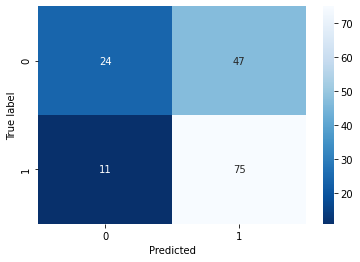

In [41]:
# построим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Проанализируем модель логистической регрессии и матрицу ошибок. 
* в 76 случаях, модель правильно отнесла вкусное молоко к категории "вкусно"
- в 10 случаях модель неправильно отнесла вкусное молоко к "не вкусно"
- в 48 случаях модель неправильно отнесла невкусное молоко к категории "вкусно"
- в 23 случаях модель правильно отнесла невкусное молоко к категории "не вкусно"

Так как для заказчика главное - вкусное молоко, ему важно, чтобы среди купленных коров не оказалось ни одной с невкусным молоком. Таким образом, нам необходимо свести FP   к нулю, тем самым максимально увеличить метрику precision. Это ошибка первого рода. Исправить ее мы сможем с помощью изменения порога принадлежности к классам.

Проведем анализ порога.

In [42]:
thresholds = [round(i,2) for i in np.linspace(0.5,1,num = 4,endpoint=False)]
thresholds

[0.5, 0.62, 0.75, 0.88]

In [43]:
# делаем оценку
y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba'])
columns = []

# добавим столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)
data.head()

,y_valid,y_proba,y_pred_0.5,y_pred_0.62,y_pred_0.75,y_pred_0.88
0,1,0.426275,0,0,0,0
1,0,0.257332,0,0,0,0
2,1,0.610393,1,0,0,0
3,0,0.458607,0,0,0,0
4,1,0.785939,1,1,1,0


In [44]:
for i in thresholds:
    print(f'y_pred_{i} precision = ', precision_score(data['y_valid'], data[f'y_pred_{i}']))

y_pred_0.5 precision =  0.6147540983606558
y_pred_0.62 precision =  0.7439024390243902
y_pred_0.75 precision =  0.9130434782608695
y_pred_0.88 precision =  0.0


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Рассмотрим промежуток подробнее. Теперь пройдем от 0.75 до 0.88

Рассмотрим порог от 0.1 до 0.2

In [45]:
thresholds = [0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86]

y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba'])
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

for i in thresholds:
    print(f'y_pred_{i} precision = ', precision_score(data['y_valid'], data[f'y_pred_{i}']))

y_pred_0.75 precision =  0.9130434782608695
y_pred_0.76 precision =  0.8888888888888888
y_pred_0.77 precision =  0.875
y_pred_0.78 precision =  0.9166666666666666
y_pred_0.79 precision =  1.0
y_pred_0.8 precision =  1.0
y_pred_0.81 precision =  1.0
y_pred_0.82 precision =  1.0
y_pred_0.83 precision =  1.0
y_pred_0.84 precision =  1.0
y_pred_0.85 precision =  1.0
y_pred_0.86 precision =  1.0


Нужно еще уменьшить масштаб порога, похоже. Пробежимся по значениям от 0.19 до 0.20.

In [46]:
thresholds = [0.781, 0.782, 0.783, 0.784, 0.785, 0.786, 0.787, 0.788, 0.789, 0.7893, 0.7895, 0.79]
y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba'])
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

for i in thresholds:
    print(f'y_pred_{i} precision = ', precision_score(data['y_valid'], data[f'y_pred_{i}']))

y_pred_0.781 precision =  0.9166666666666666
y_pred_0.782 precision =  0.9166666666666666
y_pred_0.783 precision =  0.9166666666666666
y_pred_0.784 precision =  0.9166666666666666
y_pred_0.785 precision =  0.9166666666666666
y_pred_0.786 precision =  0.9
y_pred_0.787 precision =  0.9
y_pred_0.788 precision =  0.9
y_pred_0.789 precision =  0.9
y_pred_0.7893 precision =  0.9
y_pred_0.7895 precision =  1.0
y_pred_0.79 precision =  1.0


Выберем порог 0.7895. При нем мы получим нулевую ошибку первого рода. То есть любое правильно предсказанное моделью молоко будет вкусным.

In [47]:
y_pred_new_threshold = (clf.predict_proba(X_test)[:, 1] >= 0.7895).astype(int) 
accuracy = accuracy_score(y_test, y_pred_new_threshold)
precision = precision_score(y_test, y_pred_new_threshold)
recall = recall_score(y_test, y_pred_new_threshold)
print('LogisticRegression model Accuracy = ', round(accuracy, 3))
print('LogisticRegression model Precision = ', round(precision, 3))
print('LogisticRegression model Recall = ', round(recall, 3))

LogisticRegression model Accuracy =  0.51
LogisticRegression model Precision =  1.0
LogisticRegression model Recall =  0.105


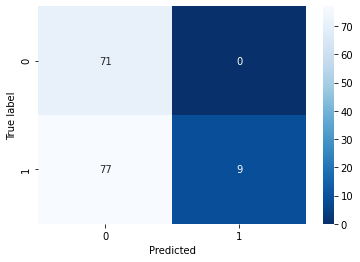

In [48]:
#матрица ошибок
cm = confusion_matrix(y_test, y_pred_new_threshold)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Точность предсказаний модели упала на 10%, зато не будет ошибаться во вкусе молока в ущерб фермеру. Теперь эту модель можно применить для анализа списка коровок для покупки.

In [49]:
cow_buy_df['эке_квадрат'] = cow_buy_df['эке (энергетическая кормовая единица)'].apply(lambda x: x**2)
cow_buy_df['спо_бинарный'] = cow_buy_df['спо (сахаро-протеиновое соотношение)'].apply(lambda x: 1 if x > 0.91 else 0)
cow_buy_df

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,эке (энергетическая кормовая единица),"сырой протеин, г",спо (сахаро-протеиновое соотношение),удой(кг),эке_квадрат,спо_бинарный
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276411,2020.092823,0.619617,6258.279596,233.368748,0
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276411,2020.092823,0.619617,6019.086077,233.368748,0
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276411,2020.092823,0.619617,5928.580076,233.368748,0
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276411,2020.092823,0.619617,6241.260709,233.368748,0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276411,2020.092823,0.619617,6190.301686,233.368748,0
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276411,2020.092823,0.619617,6060.970423,233.368748,0
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276411,2020.092823,0.619617,6258.279596,233.368748,0
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276411,2020.092823,0.619617,6218.321027,233.368748,0
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276411,2020.092823,0.619617,5928.580076,233.368748,0
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276411,2020.092823,0.619617,6042.025759,233.368748,0


In [50]:
# кодируем категориальные переменные
#encoder = OneHotEncoder(drop='first', sparse=False)
cat_col_names = ['спо_бинарный', 'тип пастбища', 'возраст']

# я оставил такое название энкордера, чтобы не перемешивалось с линейной регрессией
cow_buy_ohe = encoder.transform(cow_buy_df[cat_col_names])

cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder.get_feature_names())

# масштабируем количественные
#scaler = StandardScaler()
num_col_names = ['эке_квадрат', 'сырой протеин, г', 'текущая_жирность,%', 'текущий_уровень_белок,%']
cow_buy_scaled = scaler.transform(cow_buy_df[num_col_names])

cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)

#объединяем
cow_buy_new = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)


In [51]:
cow_buy_new.columns = ['спо_бинарный',
                       'тип пастбища_холмистое',
                       'возраст_менее_2_лет',
                       'эке_квадрат',
                       'сырой протеин, г',
                       'жирность,%',
                       'белок,%']
cow_buy_new

,спо_бинарный,тип пастбища_холмистое,возраст_менее_2_лет,эке_квадрат,"сырой протеин, г","жирность,%","белок,%"
0,0.0,1.0,0.0,0.524157,0.510781,-0.196971,0.104047
1,0.0,0.0,1.0,0.524157,0.510781,-0.446334,2.044603
2,0.0,0.0,0.0,0.524157,0.510781,-0.134630,-0.672176
3,0.0,1.0,0.0,0.524157,0.510781,-1.319106,-5.717622
4,0.0,0.0,0.0,0.524157,0.510781,0.177075,-0.672176
5,0.0,0.0,1.0,0.524157,0.510781,0.114734,-8.822512
6,0.0,1.0,0.0,0.524157,0.510781,-0.196971,0.104047
7,0.0,0.0,0.0,0.524157,0.510781,-0.259311,1.268381
8,0.0,0.0,0.0,0.524157,0.510781,-0.134630,-0.672176
9,0.0,1.0,1.0,0.524157,0.510781,-1.319106,1.268381


In [52]:
taste_pred = (clf.predict_proba(cow_buy_new)[:, 1] >= 0.7895).astype(int)
taste_pred

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

Воспользуемся полученным предсказанием. Вспомним, что 1 - вкусное молоко, 0 - невкусное. Добавим в cow_buy.

In [53]:
cow_buy_df['вкус_молока'] = taste_pred
cow_buy_df['вкус_молока'] = cow_buy_df['вкус_молока'].map({1: 'вкусно', 0: 'не вкусно'}).astype(str)

In [54]:
# теперь посмотрим, каких коров стоит купить фермеру
cow_buy_df[(cow_buy_df['удой(кг)']> 6000) & (cow_buy_df['вкус_молока'] == 'вкусно')]

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,эке (энергетическая кормовая единица),"сырой протеин, г",спо (сахаро-протеиновое соотношение),удой(кг),эке_квадрат,спо_бинарный,вкус_молока
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276411,2020.092823,0.619617,6258.279596,233.368748,0,вкусно
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276411,2020.092823,0.619617,6258.279596,233.368748,0,вкусно
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276411,2020.092823,0.619617,6218.321027,233.368748,0,вкусно
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276411,2020.092823,0.619617,6042.025759,233.368748,0,вкусно


### Вывод по второй цели работы

Итак, мы получили список из 4 коров, которые гарантированно будут давать хороший удой и давать вкусное молоко.

## Итоговые выводы

На первом этапе были прочитаны и обработаны файлы с исходными данными. Имена столбцов были приведены к нижнему регистру. Данных достаточно для работы над поставленной задачей.

#### В ходе предобработки:
* пропуски не были выявлены
- были найдены явные дубликаты, их благополучно удалили
- неявные дубликаты были приведены к единому виду
- также были изменены типы данных столбцов из object в числовые и категориальные в соответствии с смыслом столбца

#### В ходе исследовательского анализа данных:
* признак "удой" имел значительный выброс, 40-50т молока, вероятно, при вводе была ошибка, поставили лишний ноль в конце, распределение ассиметричное
- признак "ЭКЕ", "сырой протеин", "СПО" без выбросов, распределение асимметричное
-  "жирность" и белок" из ferma_main имеют выбросы, распределения ассиметричные
- признаки из cow_buy "текущий белок" и "текущая жирность" не имеют выбросов, мало данных
- значения признака "тип_пастбища" были приведены к нижнему регистру в ferma_main_df
Что касается других категориальных признаков, все в порядке.

#### Перейдем к корелляционному анализу признаков:
* целевым признаком является "удой, кг"
- линейная связь наблюдается между целевым и входным признаком - "сырой протеин"
- напротив, нелинейная связь наблюдается с входными признаками "ЭКЕ", "СПО", "жирность" и "белок"
- сильная корреляция наблюдается между целевым признаком и входными признаками: "ЭКЕ", "СПО", "возраст"
- умеренная и слабая корреляция наблюдается между целевым признаком и входными признаками: сырой протеин(г), порода папы, жирность(%), белок(%), порода, тип пастбища

В ходе работы мы провели масштабирование и трансформацию признаков, чтобы можно было с ними работать. Мультиколлинеарности не наблюдается, хотя есть признаки с достаточно высокой корелляцией (0.76).

#### Перейдем к результату работы моделей.

Мы построили три модели линейной регрессии для предсказания удоя коров, с каждым разом модель предсказывала результаты лучше, хотя по началу завышала значения. Для лучшей модели был построен доверительный интервал.

Целью работы заключалось помочь фермеру в покупке коровы. Определяющем фактором для него был вкус молока, при этом удой должен был составлять не менее 6т молока в год.
В результате проделанной работы был спрогнозирован годовой удой продаваемых коров, который варьируется от 5900 до 6260кг.

Также мы построили модель логистической регрессии для решения задачи классификации - предсказания вкуса молока.

В результате работы было выявлено 4 коровы, которые подходят фермеру под его требования

Полученный результат далек от идеала. У модели низкий процент точности,. Но мы смогли сделать так, чтобы ошибка первого рода была минимальна, и все купленные фермером коровы дадут вкусное молоко.